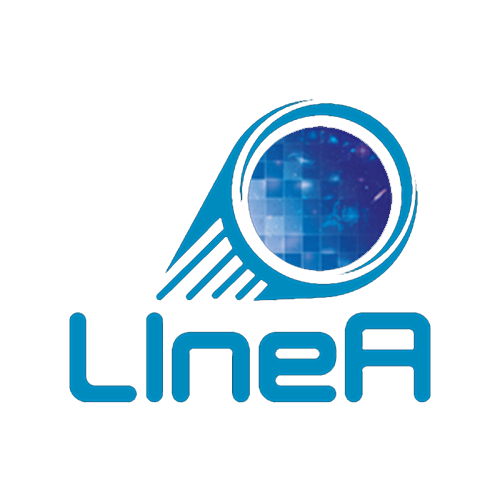

# OzDES Spectroscopic Redshifts

Inspection of basic properties of the OzDES DR2 spectroscopic catalog.

Contact: Luigi Silva ([luigi.silva@linea.org.br](mailto:luigi.silva@linea.org.br))

Last verified: June 11, 2025

### Acknowledgments

*This notebook used computational resources from the Associação Laboratório Interinstitucional de e-Astronomia (LIneA) with financial support from the INCT of e-Universo (Process no. 465376/2014-2).*

*This work makes use of data from the second OzDES data release (DR2). The OzDES survey was conducted over six observing seasons (2013–2019) using the 2dF fibre positioner and the AAOmega spectrograph on the 3.9-metre Anglo-Australian Telescope. The survey obtained over 300,000 spectra and approximately 30,000 redshifts, targeting AGN, transients, and galaxies in the 10 deep fields of the Dark Energy Survey. We acknowledge the OzDES collaboration for making these data publicly available. The survey and its data releases are described in Yuan et al. (2015, MNRAS, 452, 3047), Childress et al. (2017, MNRAS, 472, 273), and Lidman et al. (2020, MNRAS, 496, 19).*

### Introduction

This notebook contains a brief characterization of the spectroscopic redshifts (spec-z) measurements in the OzDES DR2 catalog, which has been publicly distributed and described in detail in scientific literature by OzDES project.

The data presented here were obtained following the [OzDES instruction page in Data Central](https://docs.datacentral.org.au/ozdes/overview/downloading-data/).

The schema of the catalog can be found in the [OzDES main article](https://arxiv.org/pdf/2006.00449).

### Reference paper

[Lidman et al. (2020), OzDES multi-object fibre spectroscopy for the Dark
Energy Survey: Results and second data release](https://arxiv.org/pdf/2006.00449)

# Imports and configurations of libraries

## Importing the required libraries

Importing the libraries.

In [ ]:
### GENERAL
import os
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from IPython.display import IFrame

### VISUALIZATION
# BOKEH
from bokeh.io import output_notebook

# GEOVIEWS
import geoviews as gv
import geoviews.feature as gf
from cartopy import crs

# HOLOVIEWS
import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import rasterize, dynspread

# DATASHADER
import datashader as ds

In [ ]:
hv.extension('bokeh')
gv.extension('bokeh')
output_notebook()

In [ ]:
pd.set_option("display.float_format", lambda x: f"{x:.6f}" if 1e-7 <= abs(x) <= 1e8 else f"{x:.3e}")

# Reading the entire catalog with Pandas

## Defining the path to the input files

Defining the path to the input files.

In [ ]:
input_dir = "/home/luigi/linea/new-specz-compilation/OzDES_DR2"
input_pattern = "b1417325-a49c-4a10-a52d-f230c74e682d.csv.gz"

input_files = os.path.join(input_dir, input_pattern)

## Reading the catalog

Reading the catalog with pandas.

In [ ]:
df_input = pd.read_csv(
    input_files,
    compression="gzip",
)

df_input = df_input.drop(columns=['Unnamed: 0'])

In [ ]:
df_input

## Duplicates Check

In [ ]:
duplicates = df_input["OzDES_ID"].duplicated()

print(f"Duplicates number: {duplicates.sum()}")

## Inserting the survey name as a column

In [ ]:
df_input["survey_name"] = "OZDES"

## Saving as a parquet file

In [ ]:
df_input.to_parquet("ozdes_dr2.parquet")

# Data characterization

## Number of lines and columns

In [ ]:
input_nrows = len(df_input)

print(f"Total number of lines (full catalog): {input_nrows}")

In [ ]:
input_cols = df_input.columns
input_ncols = len(input_cols)

print(f"Total number of columns (full catalog): {input_ncols}")

In [ ]:
print("Columns names (full catalog): \n")
print(input_cols.to_list())

## First lines of the catalog

In [ ]:
df_input.head()

## Basic statistics

In [ ]:
df_input.describe()

## Plots

### Common parameters

In [ ]:
ra_column_name = 'Alpha_J2000'
dec_column_name = 'Delta_J2000'
z_column_name = 'z'

### Spatial distribution plot

Getting RA and DEC columns in the dataframe.

In [ ]:
df_ra_dec = df_input[[ra_column_name, dec_column_name]].copy()

Changing RA to the $[-180^{\circ}, 180^{\circ})$ interval.

In [ ]:
ra_column_name_shifted = ra_column_name+'_shifted'

df_ra_dec.loc[:, ra_column_name_shifted] = ((df_ra_dec[ra_column_name] + 180) % 360) - 180

#### Plot using the Plate Carrée projection

Defining the points element.

In [ ]:
hv_points = hv.Points(df_ra_dec[[ra_column_name_shifted, dec_column_name]], kdims=[ra_column_name_shifted,  dec_column_name])

Defining the title, the axis labels and the plot sizes.

In [ ]:
title = 'Spatial Distribution - Plate Carrée Projection'
height = 500
width = 1000
padding = 0.05

Making the plot with geoviews and datashader.

In [ ]:
Plate_Carree_rasterized_points = rasterize(hv_points, aggregator=ds.count()).opts(cmap="Viridis", cnorm='log')

Plate_Carree_spread_points = dynspread(Plate_Carree_rasterized_points).opts(
    width=width, height=height, padding=padding, title=title, toolbar='above', colorbar=True,
    tools=['box_select'], show_grid=True, 
    invert_xaxis=True  
)

# For a dynamic plot, uncoment the line below.
Plate_Carree_spread_points

In [ ]:
#hv.save(Plate_Carree_spread_points, 'plate_carree_spatial_distribution.html', backend='bokeh')

In [ ]:
#IFrame('plate_carree_spatial_distribution.html', width=1200, height=600)

#### Plot using the Mollweide projection

Defining the points element.

In [ ]:
gv_points = gv.Points(df_ra_dec[[ra_column_name_shifted, dec_column_name]], kdims=[ra_column_name_shifted, dec_column_name]).opts(
    projection=crs.PlateCarree()
)

Defining the title, the axis labels and the plot sizes.

In [ ]:
title = 'Spatial Distribution - Mollweide Projection'
height = 500
width = 1000
padding = 0.05

Defining the RA and DEC ticks for the Mollweide projection.

In [ ]:
longitudes = np.arange(30, 360, 30)
latitudes = np.arange(-75, 76, 15)

lon_labels = [f"{lon}°" for lon in longitudes]
lon_labels.reverse()
lat_labels = [f"{lat}°" for lat in latitudes]

labels_data = {
    "lon": list(np.flip(longitudes)) + [180] * len(latitudes),
    "lat": [0] * len(longitudes) + list(latitudes),
    "label": lon_labels + lat_labels,
}

df_labels = pd.DataFrame(labels_data)

labels_plot = gv.Labels(df_labels, kdims=["lon", "lat"], vdims=["label"]).opts(
    text_font_size="12pt",
    text_color="black",
    text_align='right',
    text_baseline='bottom',
    projection=crs.Mollweide()
)

Making the plot with datashader.

In [ ]:
Mollweide_rasterized_points = rasterize(gv_points, aggregator=ds.count()).opts(cmap="Viridis", cnorm='log')

Mollweide_spread_points = dynspread(Mollweide_rasterized_points).opts(
    width=width, height=height, padding=padding, title=title, toolbar='above', colorbar=True,
    invert_xaxis=True
)

grid = gf.grid()

final_mollweide_plot = (Mollweide_spread_points).opts(
    opts.RGB(projection=crs.Mollweide())
) * grid * labels_plot

# For a dynamic plot, uncoment the line below.
final_mollweide_plot

In [ ]:
#hv.save(final_mollweide_plot, 'mollweide_spatial_distribution.html', backend='bokeh')

In [ ]:
#IFrame('mollweide_spatial_distribution.html', width=1200, height=600)

#### Redshift plot

In [ ]:
z_values = df_input[z_column_name]

In [ ]:
redshift = hv.Dimension(z_column_name, label='spec-z')
(count, z_bin) = np.histogram(z_values, bins=np.arange(0,15,0.02))

In [ ]:
z_distribution = hv.Histogram((count, z_bin), kdims=redshift).opts(
    title='Redshift Distribution', xlabel='spec-z', height=400, width=800,  xlim=(0.,1.5))   
z_distribution